In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split the dataset: Train (70%), Validation (15%), Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Combine X_train and y_train into one DataFrame
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Save to CSV files
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

print("Training, validation, and test data saved to separate files:")
print(" - train_data.csv (training set)")
print(" - val_data.csv (validation set)")
print(" - test_data.csv (test set)")

Train size: 9408, Validation size: 2016
Starting Grid Search for LinearRegression...
Starting Grid Search for RandomForest...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for RandomForest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


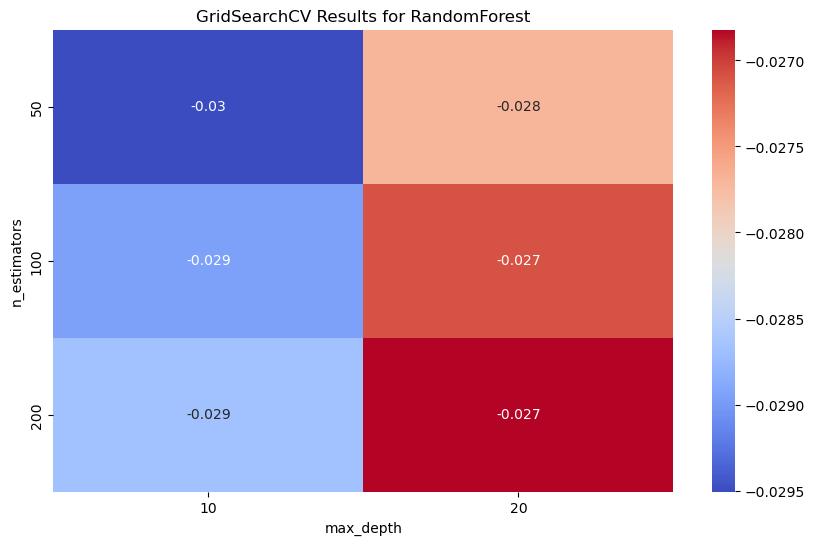

Starting Grid Search for XGBoost...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


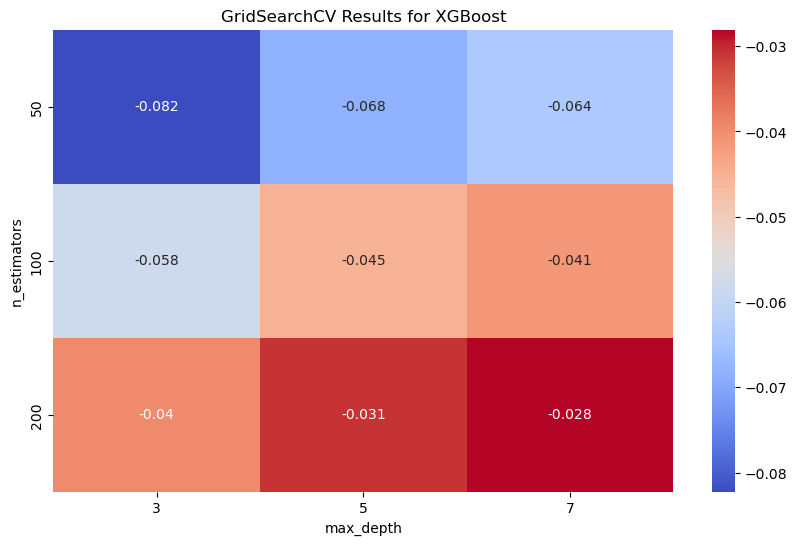


Validation Results:
LinearRegression: Validation MSE = 0.0621
LinearRegression: Validation R_2 score = 0.8158
RandomForest: Validation MSE = 0.0248
RandomForest: Validation R_2 score = 0.9263
XGBoost: Validation MSE = 0.0221
XGBoost: Validation R_2 score = 0.9343
Saved best model for LinearRegression.
Saved best model for RandomForest.
Saved best model for XGBoost.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
file_path = 'preprocessed_dataset.csv'
data = pd.read_csv(file_path)

# Separate features (X) and target (y)
X = data.drop(columns=['SALE_PRC_log'])
y = data['SALE_PRC_log']

# Load the datasets
train_data = pd.read_csv("train_data.csv")
val_data = pd.read_csv("val_data.csv")

# Split into features (X) and target (y)
X_train = train_data.drop(columns=["SALE_PRC_log"])  # Replace 'SALE_PRC_log' with the actual target column name
y_train = train_data["SALE_PRC_log"]

X_val = val_data.drop(columns=["SALE_PRC_log"])
y_val = val_data["SALE_PRC_log"]

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}")

# Define the models
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Define hyperparameter grids
param_grids = {
    "LinearRegression": {},
    "RandomForest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.8, 1.0]
    }
}

# Perform Grid Search for each model and capture tuning results for visualization
best_models = {}
for model_name, model in models.items():
    print(f"Starting Grid Search for {model_name}...")
    param_grid = param_grids[model_name]
    
    # Skip GridSearchCV for Linear Regression since it has no parameters to tune
    if not param_grid:
        best_models[model_name] = model.fit(X_train, y_train)
        continue
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',  # Use negative MSE as scoring
        cv=3,  # 3-fold cross-validation
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_

    # Print best parameters
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    # Visualize the tuning process for RandomForest and XGBoost
    if model_name in ["RandomForest", "XGBoost"]:
        results = pd.DataFrame(grid_search.cv_results_)

        # For RandomForest, create a pivot table of n_estimators vs max_depth
        if model_name == "RandomForest":
            mean_scores = results.pivot_table('mean_test_score', 'param_n_estimators', 'param_max_depth')

            plt.figure(figsize=(10, 6))
            sns.heatmap(mean_scores, annot=True, cmap='coolwarm', cbar=True)
            plt.title(f"GridSearchCV Results for {model_name}")
            plt.xlabel('max_depth')
            plt.ylabel('n_estimators')
            plt.show()

        # For XGBoost, create a pivot table of n_estimators vs max_depth
        elif model_name == "XGBoost":
            mean_scores = results.pivot_table('mean_test_score', 'param_n_estimators', 'param_max_depth')

            plt.figure(figsize=(10, 6))
            sns.heatmap(mean_scores, annot=True, cmap='coolwarm', cbar=True)
            plt.title(f"GridSearchCV Results for {model_name}")
            plt.xlabel('max_depth')
            plt.ylabel('n_estimators')
            plt.show()

# Evaluate models on the validation set
print("\nValidation Results:")
for model_name, model in best_models.items():
    y_val_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    print(f"{model_name}: Validation MSE = {mse:.4f}")
    r2 = r2_score(y_val, y_val_pred)
    print(f"{model_name}: Validation R_2 score = {r2:.4f}")

# Save the best models
import joblib
for model_name, model in best_models.items():
    joblib.dump(model, f"{model_name}_best_model.pkl")
    print(f"Saved best model for {model_name}.")
